# Pseudo JV analysis code

Using pseudo JV data, JV data, and PLQY data, this notebook can plot JV, pJV, and iJV of a solar cell and use that data to calculate series resistance.   
<br>
Other necessary files:
PowerCurrent_Averaged.csv; 
SQ.csv; 
Detector_responsivity.csv

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from natsort import natsorted
from tqdm import tqdm

Set save_fig = True if you want to save figures

In [2]:
save_fig = False

Load psuedo JV data in, modify file name:

In [3]:
pJVdata = pd.read_csv("PSK_pJV_data.csv") #pseudo JV data
sq = pd.read_csv('SQ.csv', index_col='Eg')
ref = pd.read_csv('PowerCurrent_Averaged.csv', index_col='currents')
ref.index = np.round(ref.index, decimals = 1)

Load JV data, if you have it: 

In [4]:
#If have JV data, read csv here, comment out if not:
JVdata = pd.read_csv("PSK_JV_data.csv")

Load PLQY data if you have it.  <br>Insert as folder in cwd.

In [5]:
#Optional loading PLQY data, still works if not available
currents = {}
data = {}
path = os.getcwd()
# List directories in the current working directory
directories = [n for n in os.listdir() if os.path.isdir(n)]
# Check if there are directories
if not directories:
    sample_names = ['S0_placeholder']
    for n in sample_names:
        currents[n] = np.arange(300, 800, 20)
        data[n] = {}
        data[n]['powers'] = np.array(ref['power'][currents[n]])*1000 #watts to mW

else:
    # Sort and process directory names
    sample_names = natsorted(directories)
    fids = {}
    for n in sample_names:
        s_path = os.path.join(path, n)
        fids[n] = natsorted([os.path.join(s_path, f) for f in os.listdir(s_path) if '.csv' in f])
    for n in sample_names:
        currents[n] = [np.round(float(f.split("_")[-1][:-4]), decimals=1) for f in fids[n]]
        data[n] = {}
        data[n]['powers'] = np.array(ref['power'][currents[n]])*1000 #watts to mW
        data[n]['pJV_Voc'] = pJVdata['Voc (V)']
        data[n]['JV_V'] = JVdata['Voltage (V)']
        data[n]['JV_J'] = JVdata['Current Density (mA/cm2)']

In [6]:
def load_plqy(fid):

    """Simple function to load .csv plqy data

    Args:
        fid (str): file path, should be .csv

    Returns:
        pd.DataFrame: a data frame containing the six scan types necessary to calculate PLQY
    """

    df = pd.read_csv(fid)
    
    return df
    
def calc_plqy_deMello(data: pd.DataFrame, sample_wl: float, sample_resp: float, laser_wl: float, laser_resp: float):

    """A function to calculate the PLQY based in a publication by de Mello et al.
       The most widely used method for calculating PLQY.
       https://doi.org/10.1002/adma.19970090308

    Args:
        data (pd.DataFrame): dataframe loaded in using the load_plqy() function
        sample_wl (float): the peak emission wavelength of the sample
        sample_resp (float): the responsivity of the detector at sample_wl
        laser_wl (float): the emission wavelength of the laser. Probably 532.0nm
        laser_resp (float): the responsivity of the detector at the laser_wl

    Returns:
        tuple: (PLQY, PLQY error), resported as fractional, not percentage
    """

    E_in = data['in_lp'].mean()
    E_in_err = data['in_lp'].std()/E_in

    E_out = data['out_lp'].mean()
    E_out_err = data['out_lp'].std()/E_out

    X_in = data['in_nolp'].mean() - E_in
    X_in_err = (data['in_nolp'].std()/X_in) + E_in_err

    X_out = data['out_nolp'].mean() - E_out
    X_out_err = (data['out_nolp'].std()/X_out) + E_out_err

    X_empty = data['empty_nolp'].mean() - data['empty_lp'].mean()
    X_empty_err = (data['empty_nolp'].std()/data['empty_nolp'].mean()) + (data['empty_lp'].std()/data['empty_lp'].mean())

    E_in = E_in*(sample_wl/sample_resp)
    E_out = E_out*(sample_wl/sample_resp)

    X_in = X_in*(laser_wl/laser_resp)
    X_out = X_out*(laser_wl/laser_resp)
    X_empty = X_empty*(laser_wl/laser_resp)

    a = (X_out-X_in)/X_out
    a_err = np.sqrt(((X_out_err + X_in_err)**2) + (X_out_err**2))

    plqy = (E_in-(1-a)*E_out)/(X_empty*a)
    plqy_err = np.sqrt((E_in_err**2) + ((E_out_err + a_err)**2) + (X_empty_err**2))

    return plqy, plqy_err*plqy

def get_responsivity(emission_wl):
    """internal function to get the respnsivity of the detector at the emission wavelength

    Args:
        emission_wl (float): the mean emission wavelength of the sample

    Returns:
        float: the responsivity, arbitrary units
    """
    try:
        resp = pd.read_csv('Detector_Responsivity.csv')

        return float(resp['Responsivity'][resp['Wavelength'] == emission_wl])

    except: # if not, tell the user to do so
        print(f'Detector_Responsivity.csv not able to load...check code')

Define constants based on material used:

In [7]:
EMISSION_WL = 808  #modify this based on bandgap
LASER_SPOT_SIZE = 0.066 #cm2
kT = 0.026 #eV
LASER_WL = 532
REFLECTION_LOSSES = 0.10 # fraction of 1 taken off of the Jsc to make implied curve more real, modify as needed
EMISSION_RESP = get_responsivity(EMISSION_WL)
LASER_RESP = get_responsivity(LASER_WL)

Store all S-Q limit data:

In [8]:
data[n]['Eg'] = np.round(1240/EMISSION_WL, decimals=2)
data[n]['Voc_rad'] = sq['Voc'][data[n]['Eg']]
data[n]['Jsc_rad'] = sq['Jsc'][data[n]['Eg']]
data[n]['Suns'] = (data[n]['powers']/LASER_SPOT_SIZE)/sq['laser power'][data[n]['Eg']]  
data[n]['qfls_rad'] = data[n]['Voc_rad'] + kT*np.log(data[n]['Suns'])
data[n]['implied_current'] = data[n]['Jsc_rad']*(1-REFLECTION_LOSSES)*(1-data[n]['Suns'])
data[n]['implied_current_limit'] = data[n]['Jsc_rad']*(1-data[n]['Suns'])

If plqy data exists: calcualte PLQY and QFLS

In [9]:
# If plqy data, calculate plqy, if not pass
if "fids" in dir():
    for n in sample_names:
        temp_plqys = []
        temp_errs = []
    
        for fid in tqdm(fids[n]):

            deMello = calc_plqy_deMello(load_plqy(fid), EMISSION_WL, EMISSION_RESP, LASER_WL, LASER_RESP)
            temp_plqys.append(deMello[0])
            temp_errs.append(deMello[1])

        data[n]['plqy'] = np.array(temp_plqys)
        data[n]['plqy_err'] = np.array(temp_errs)
        data[n]['plqy'][data[n]['plqy'] < 0] = np.nan
        data[n]['qfls'] = data[n]['Voc_rad'] + kT*np.log(data[n]['Suns']*data[n]['plqy'])
        data[n]['qfls_err'] = np.log(1 + data[n]['plqy_err']/data[n]['plqy'])
        data[n]['qfls_rad'] = data[n]['Voc_rad'] + kT*np.log(data[n]['Suns'])

else:
    pass

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 353.33it/s]


Modify sample name how you want it to be labeled:

In [10]:
sample_names_description = {
    'S0': 'PSK_baseline',
    }

Plot Suns Voc, display ideality factor:

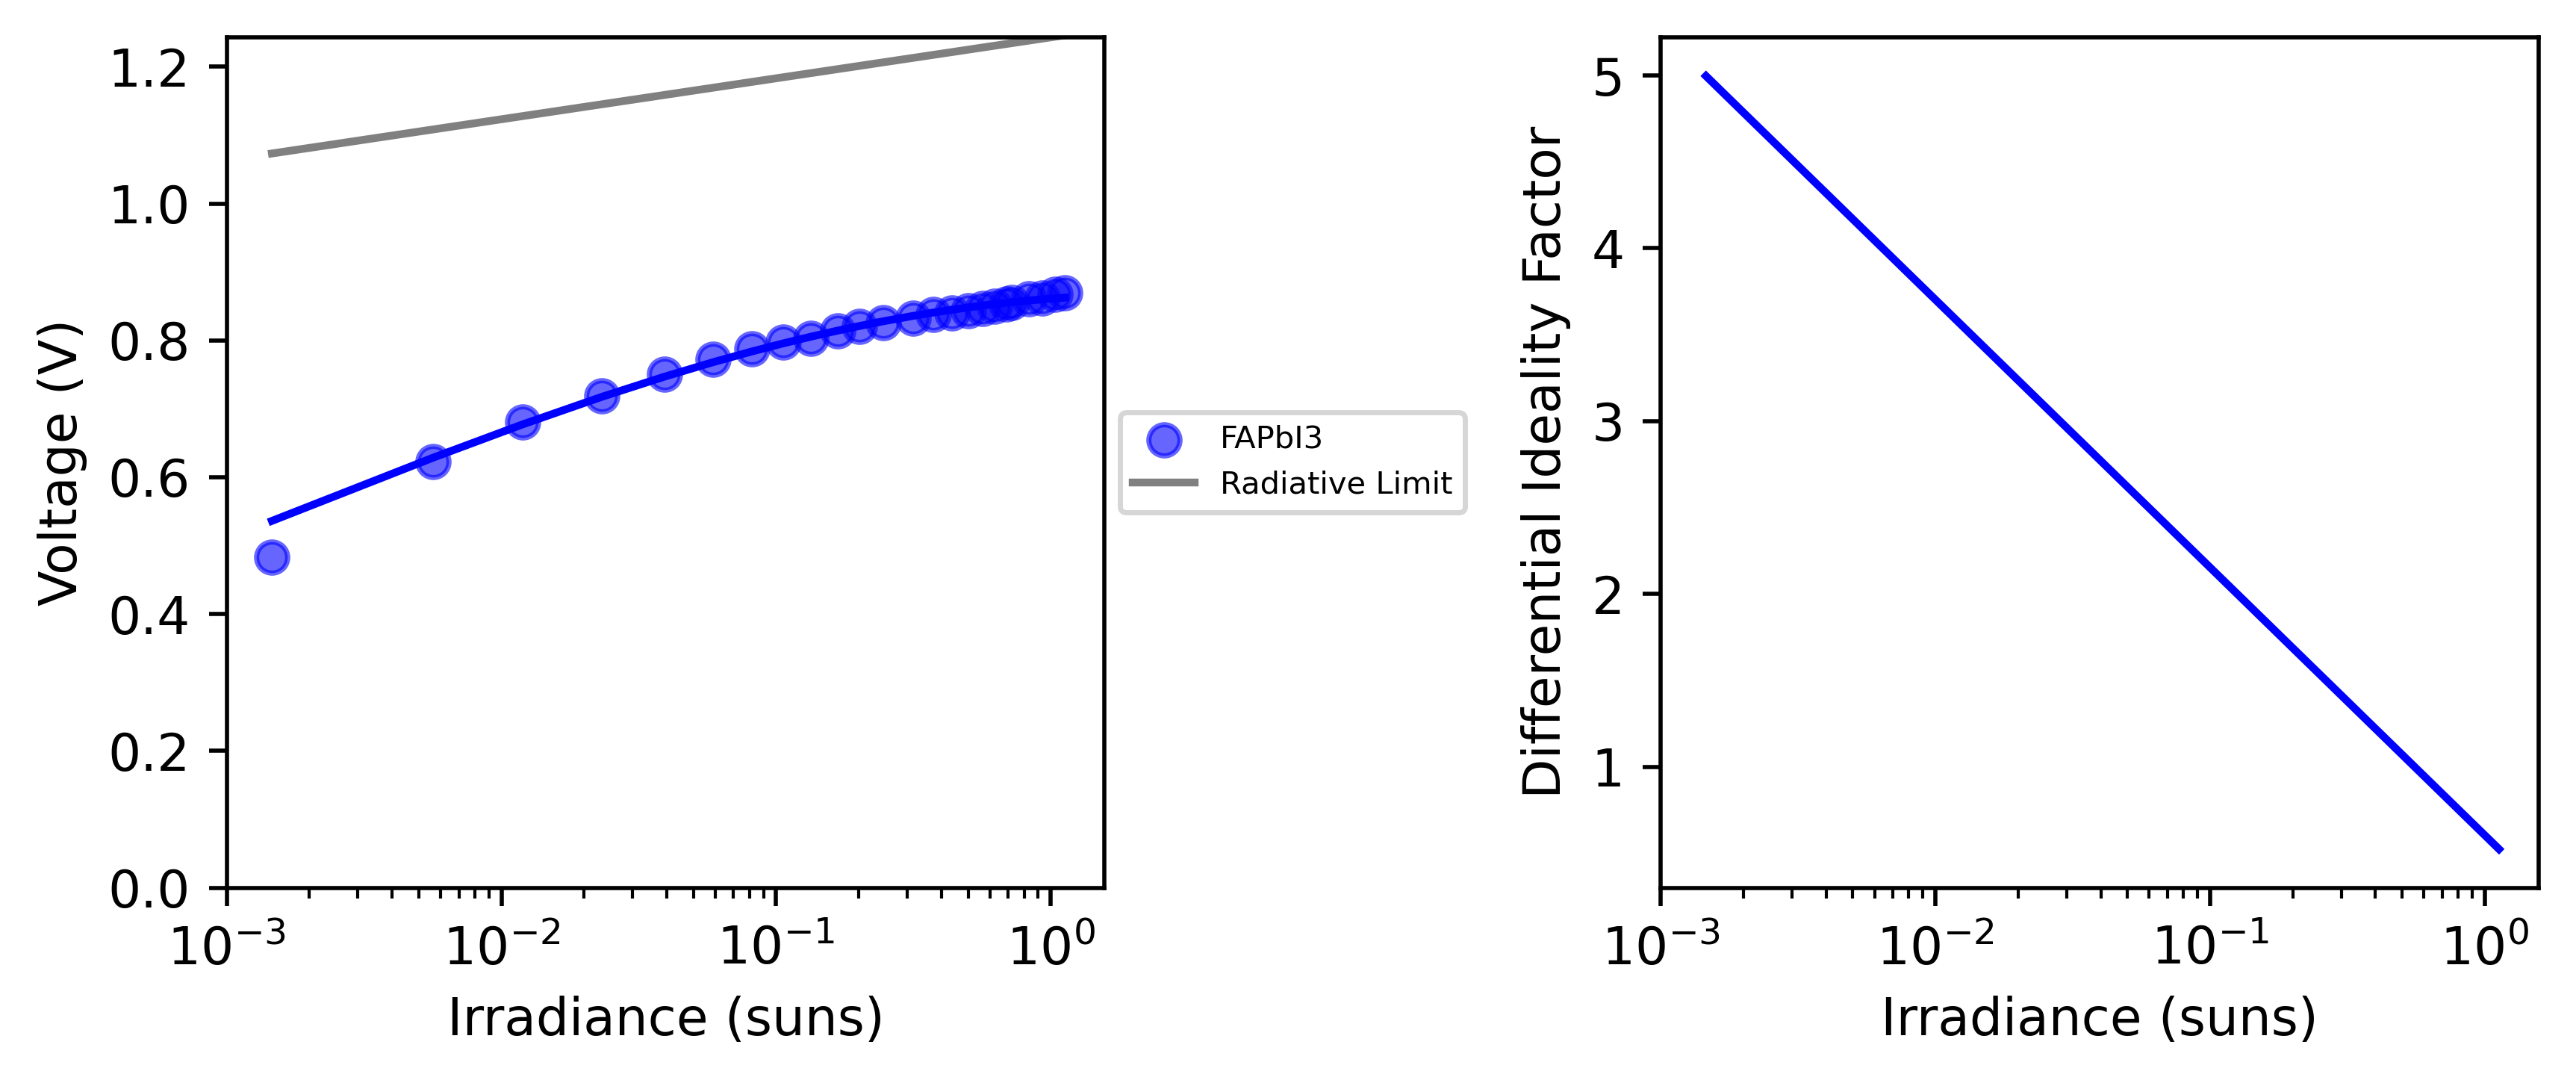

In [11]:
fig, axs = plt.subplots(1,2,figsize = (7,3), dpi = 500)
start_index = 1 #adjust start_index as needed to fit data
x = data[n]["Suns"][start_index:]
y = pJVdata['Voc (V)'][start_index:]
axs[0].scatter(x, y, label='FAPbI3', color = "blue", alpha = 0.6)
x_fit = np.log(x)[start_index:]
y_fit = np.log(y)[start_index:]
a,b,c = np.polyfit(x_fit, y_fit, 2)
best_fit = np.exp(a*np.log(x)*np.log(x) + b*np.log(x) + c)
dydx = (2*a*np.log(x) + b)/0.0259
data[n]['best_fit'] = best_fit
data[n]['dydx_fit'] = dydx
axs[0].plot(x, best_fit, linestyle = 'solid', color = "blue")
axs[1].plot(x, dydx, linestyle = 'solid', color = "blue")
axs[0].plot(x, data[n]['qfls_rad'][start_index:], label = 'Radiative Limit', color = 'gray')

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].set_ylabel("Voltage (V)")
axs[1].set_ylabel('Differential Ideality Factor')
axs[0].set_ylim(bottom = 0, top = data[n]['Voc_rad'])

axs[0].set_xlim(1e-3,)
axs[1].set_xlim(1e-3,)

axs[0].set_xlabel('Irradiance (suns)')
axs[1].set_xlabel('Irradiance (suns)')

axs[0].legend(fontsize=6, frameon=True, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
if save_fig == True:
    plt.savefig("SunsVOC_Ideality_Factor.png")


Pseudo JV and Radiative limit:

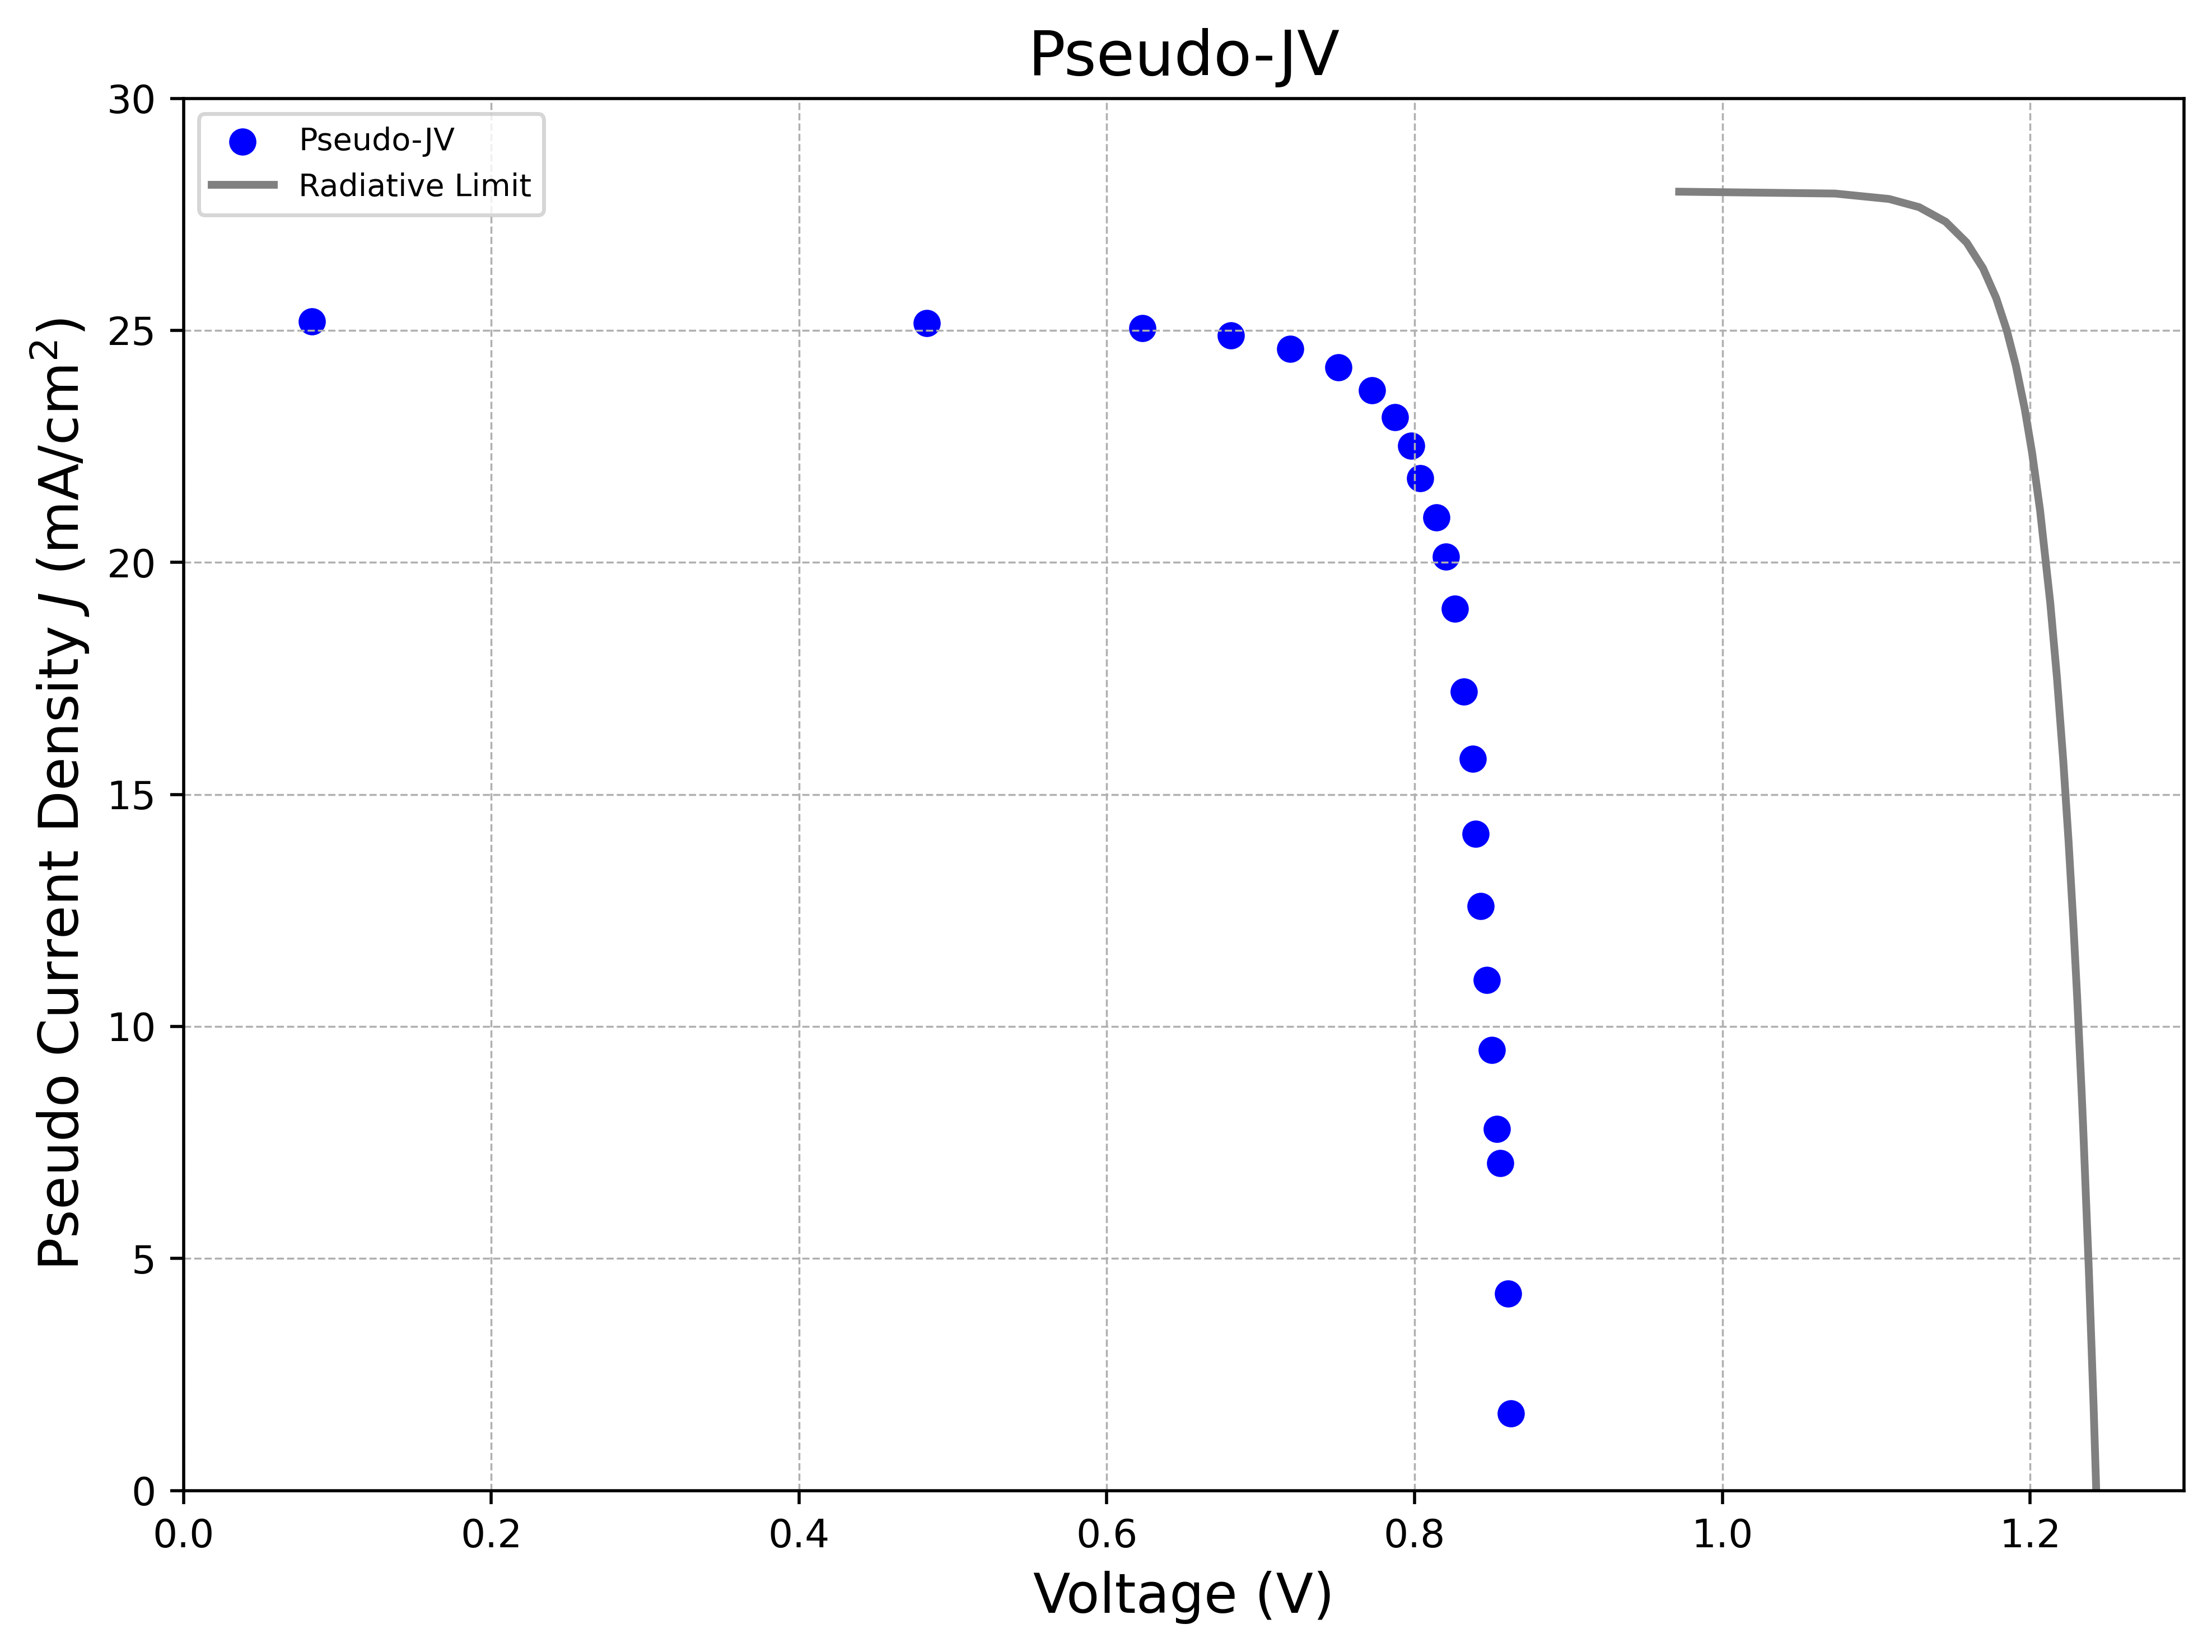

In [12]:
# Increase figure size
plt.figure(figsize=(8, 6), dpi = 500)
# PsuedoJV:
plt.scatter(pJVdata['Voc (V)'], data[n]['implied_current'], c='blue', marker='o', label='Pseudo-JV')
# Radiative limit:
plt.plot(data[n]['qfls_rad'], data[n]['implied_current_limit'], label='Radiative Limit', color='gray', linewidth=2)
plt.xlabel('Voltage (V)', fontsize=14)
plt.ylabel(r'Pseudo Current Density $J$ (mA/cm$^{2}$)', fontsize=14)
plt.title("Pseudo-JV", fontsize=16)
plt.ylim(bottom=0, top=30)
plt.xlim(left=0.0, right=np.ceil(10 * data[n]['Voc_rad']) / 10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize = 8, loc = "best")
plt.tight_layout()
if save_fig == True:
    plt.savefig("pJV.png", facecolor='white', bbox_inches='tight')


Series resistance calculation:

In [13]:
# Calculate the power for each pair of voltage and current_density
if 'JVdata' in dir(): 
    j = data[n]['JV_J']
    voltage = data[n]['JV_V']
    Voc = data[n]['pJV_Voc']
    pseudo_J = data[n]['implied_current'] = data[n]['Jsc_rad']*(1-REFLECTION_LOSSES)*(1-data[n]['Suns'])
    power = [v * i for v, i in zip(voltage, j)]
    # Find the index of the maximum power
    mpp = max(power)
    index_mpp = power.index(mpp)
    # Get the current_density and voltage values corresponding to the maximum power
    current_density_mpp = j[index_mpp]
    voltage_mpp = voltage[index_mpp]
    print("Max power point =", mpp, "mW/cm^2 at Jmpp = ", current_density_mpp, "mA/cm^2 and Vmpp =", voltage_mpp, "V")
    
    #use current_density_mpp to find the closest value of pseudo_J 
    diffs = [abs(current_density_mpp - i) for i in pseudo_J]
    min_j_diff = min(diffs)
    #find index of that pseudoJ value
    index_min_j_diff = diffs.index(min_j_diff)

    #use that index to find corresponding Voc
    Voc_mpp = Voc[index_min_j_diff]
    #find the abs value difference between Voc and voltage and divide by the current density, that equyals series_resistance
    r_series = (abs(voltage_mpp - Voc_mpp))*1000 / current_density_mpp

    # Get the corresponding Voc value at that index
    #nearest_voltage = Voc[smallest_difference]
    #print("Voltage at the nearest current density on the Pseudo-JV curve:", nearest_voltage, "V")
    #r_series = (nearest_voltage- voltage_max_power)*1000 / current_density_max_power
    print("Series resistance =", r_series, "Ohms*cm^2")

else:
    pass

Max power point = 14.601348988338193 mW/cm^2 at Jmpp =  22.47772857142857 mA/cm^2 and Vmpp = 0.6495918367346939 V
Series resistance = 6.599157152108929 Ohms*cm^2


JV, pJV, SQ limit:

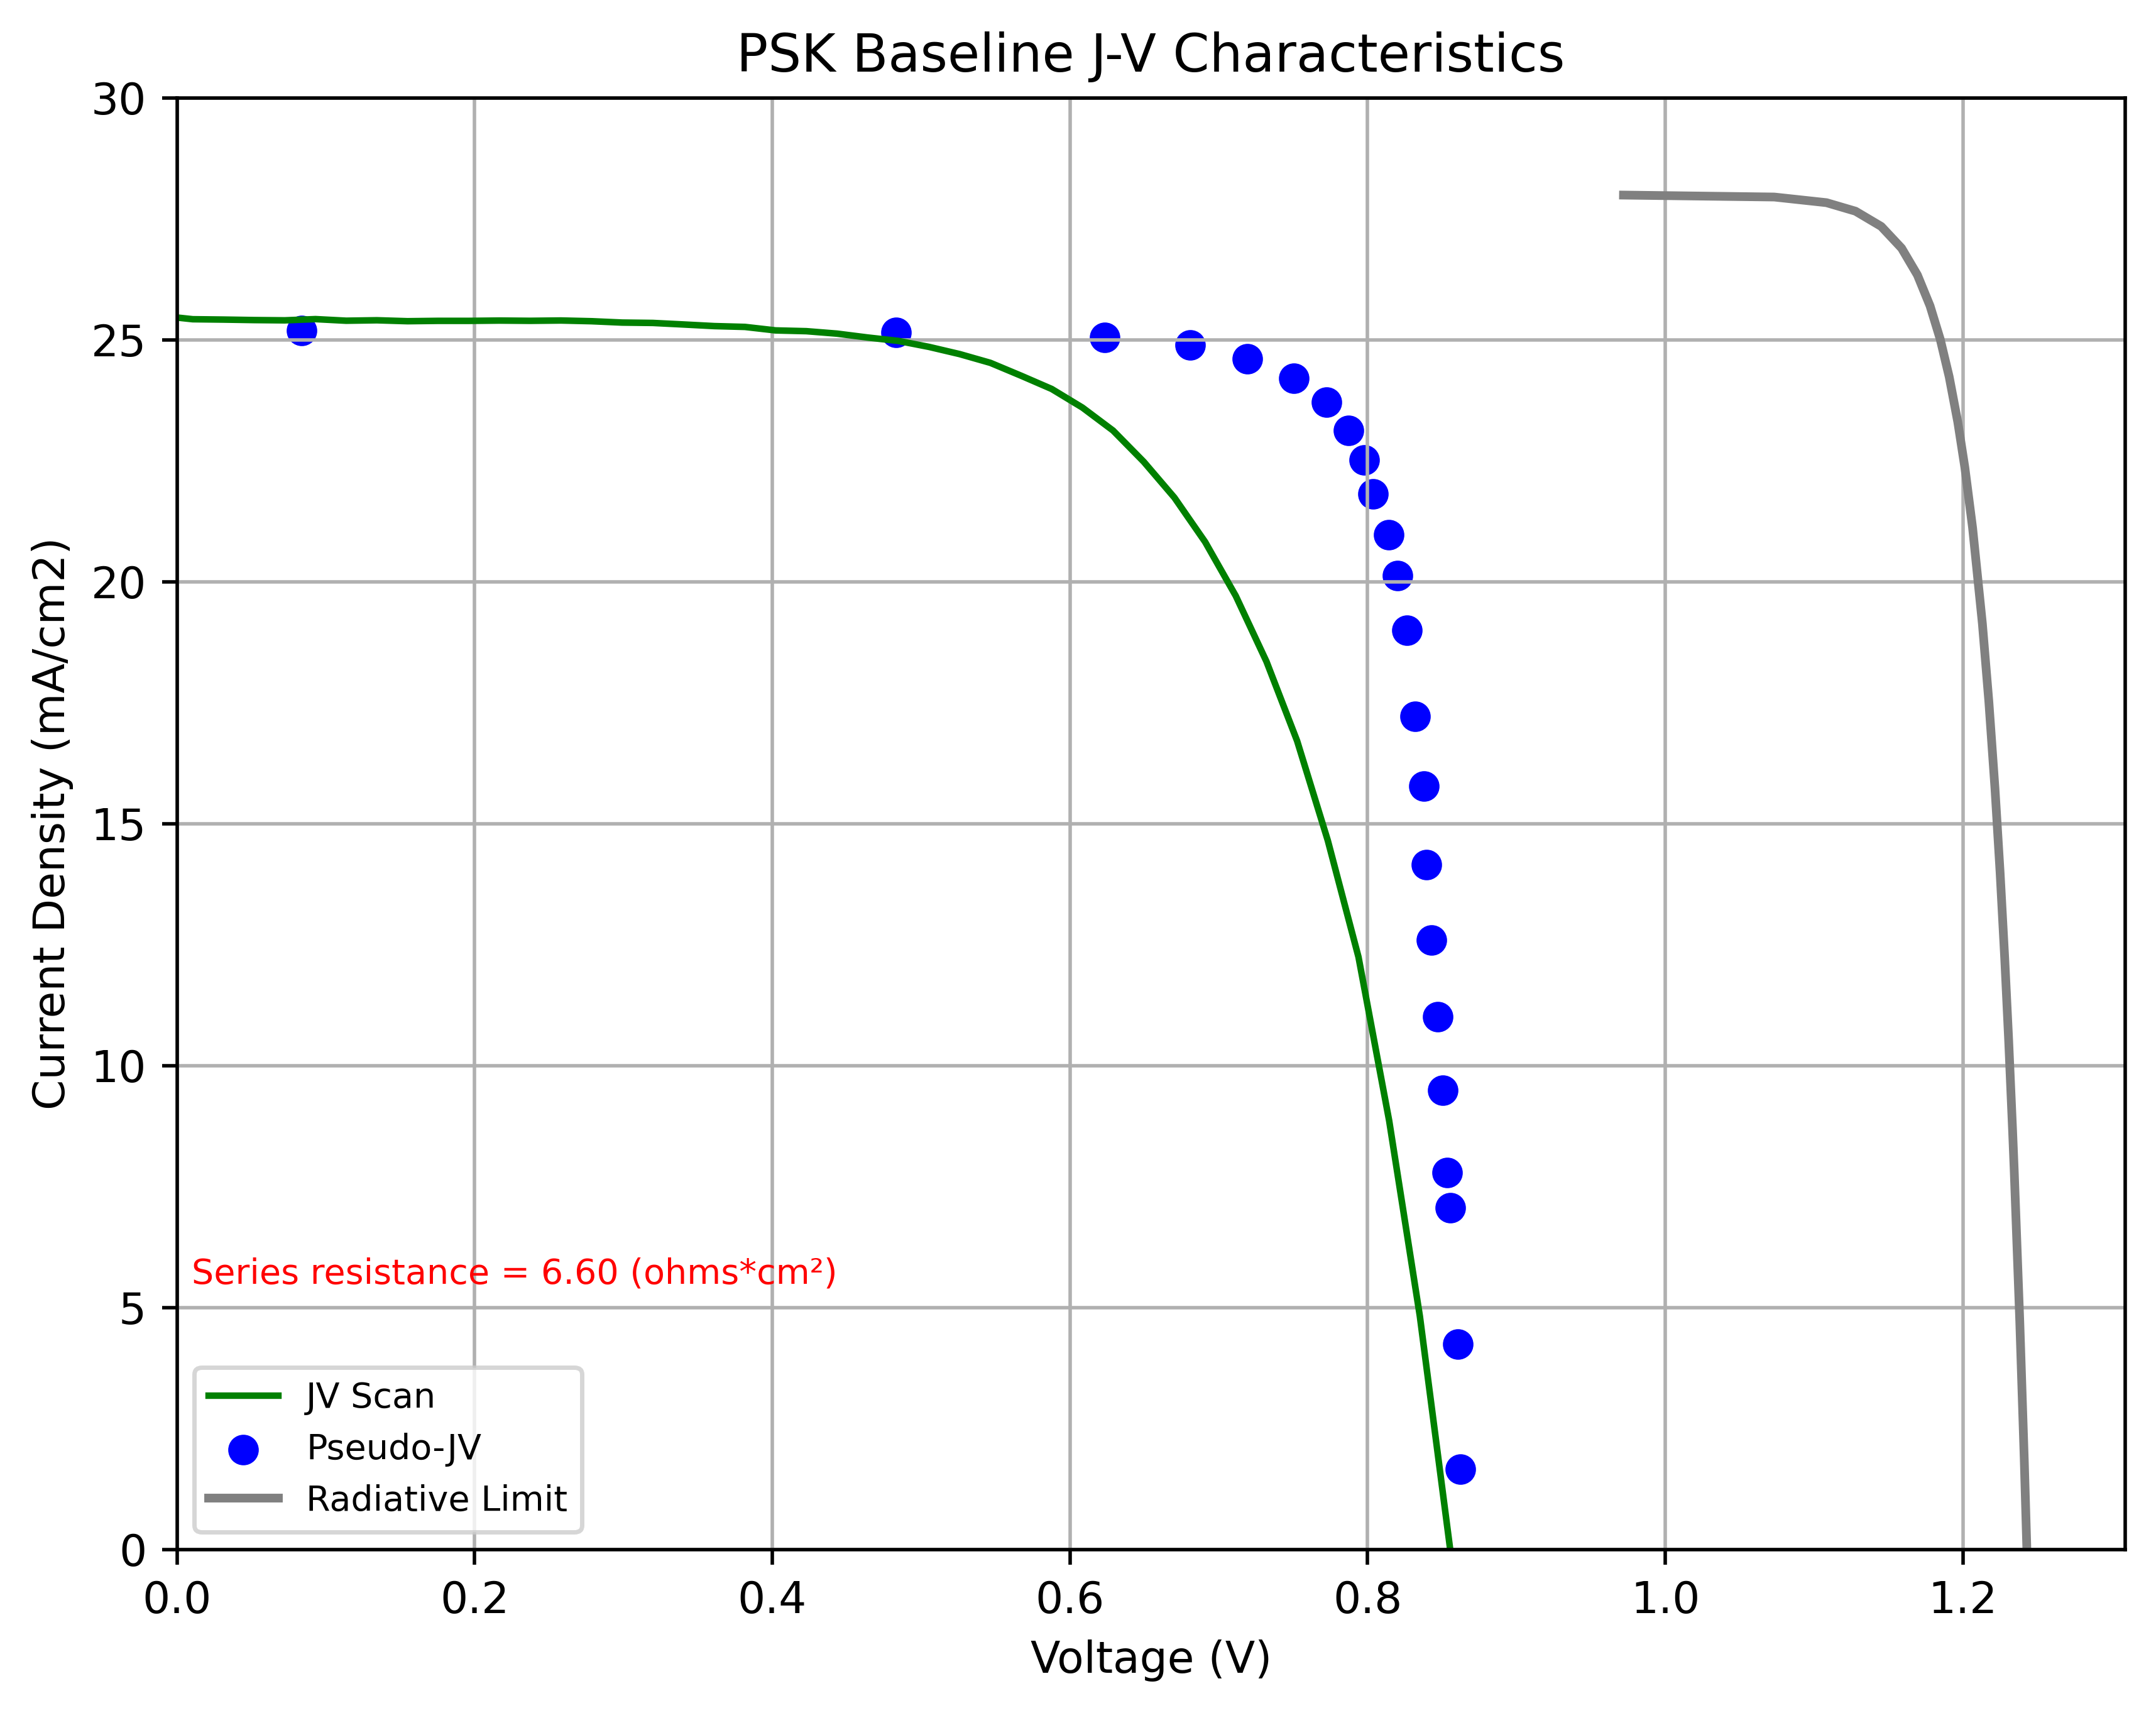

In [14]:
# JV, pJV, radLimit
if "JVdata" in dir():
    plt.figure(figsize=(8, 6), dpi= 500)
    plt.plot(data[n]["JV_V"], data[n]['JV_J'], label="JV Scan", color='green')
    plt.scatter(data[n]['pJV_Voc'], data[n]['implied_current'], c='blue', marker='o', label='Pseudo-JV')
    plt.plot(data[n]['qfls_rad'], data[n]['implied_current_limit'], label='Radiative Limit', color='gray', linewidth=2)
    plt.xlabel("Voltage (V)")
    plt.ylabel("Current Density (mA/cm2)")
    plt.title("PSK Baseline J-V Characteristics")
    plt.grid(True)
    plt.ylim(0,30)
    plt.xlim(0)
    plt.legend(fontsize = 8, loc = "lower left")
    Eg = data[n]['Eg']
    legend_text = f'Series resistance = {r_series:.2f} (ohms*cm²)'  # Format the text with two decimal places
    plt.text(0.01, 5.5, legend_text, fontsize=8, color='red')  # Adjust the coordinates and style as needed
    if save_fig == True:
        plt.savefig("pJV+JV.png")

else:
    print("Load JV csv data in cwd")

JV, pJV, iJV, SQ limit, series resistance: 

Assumptions: 
Reflection losses 0.1 
Emission WL = 808 nm, bandgap 1.53 ev


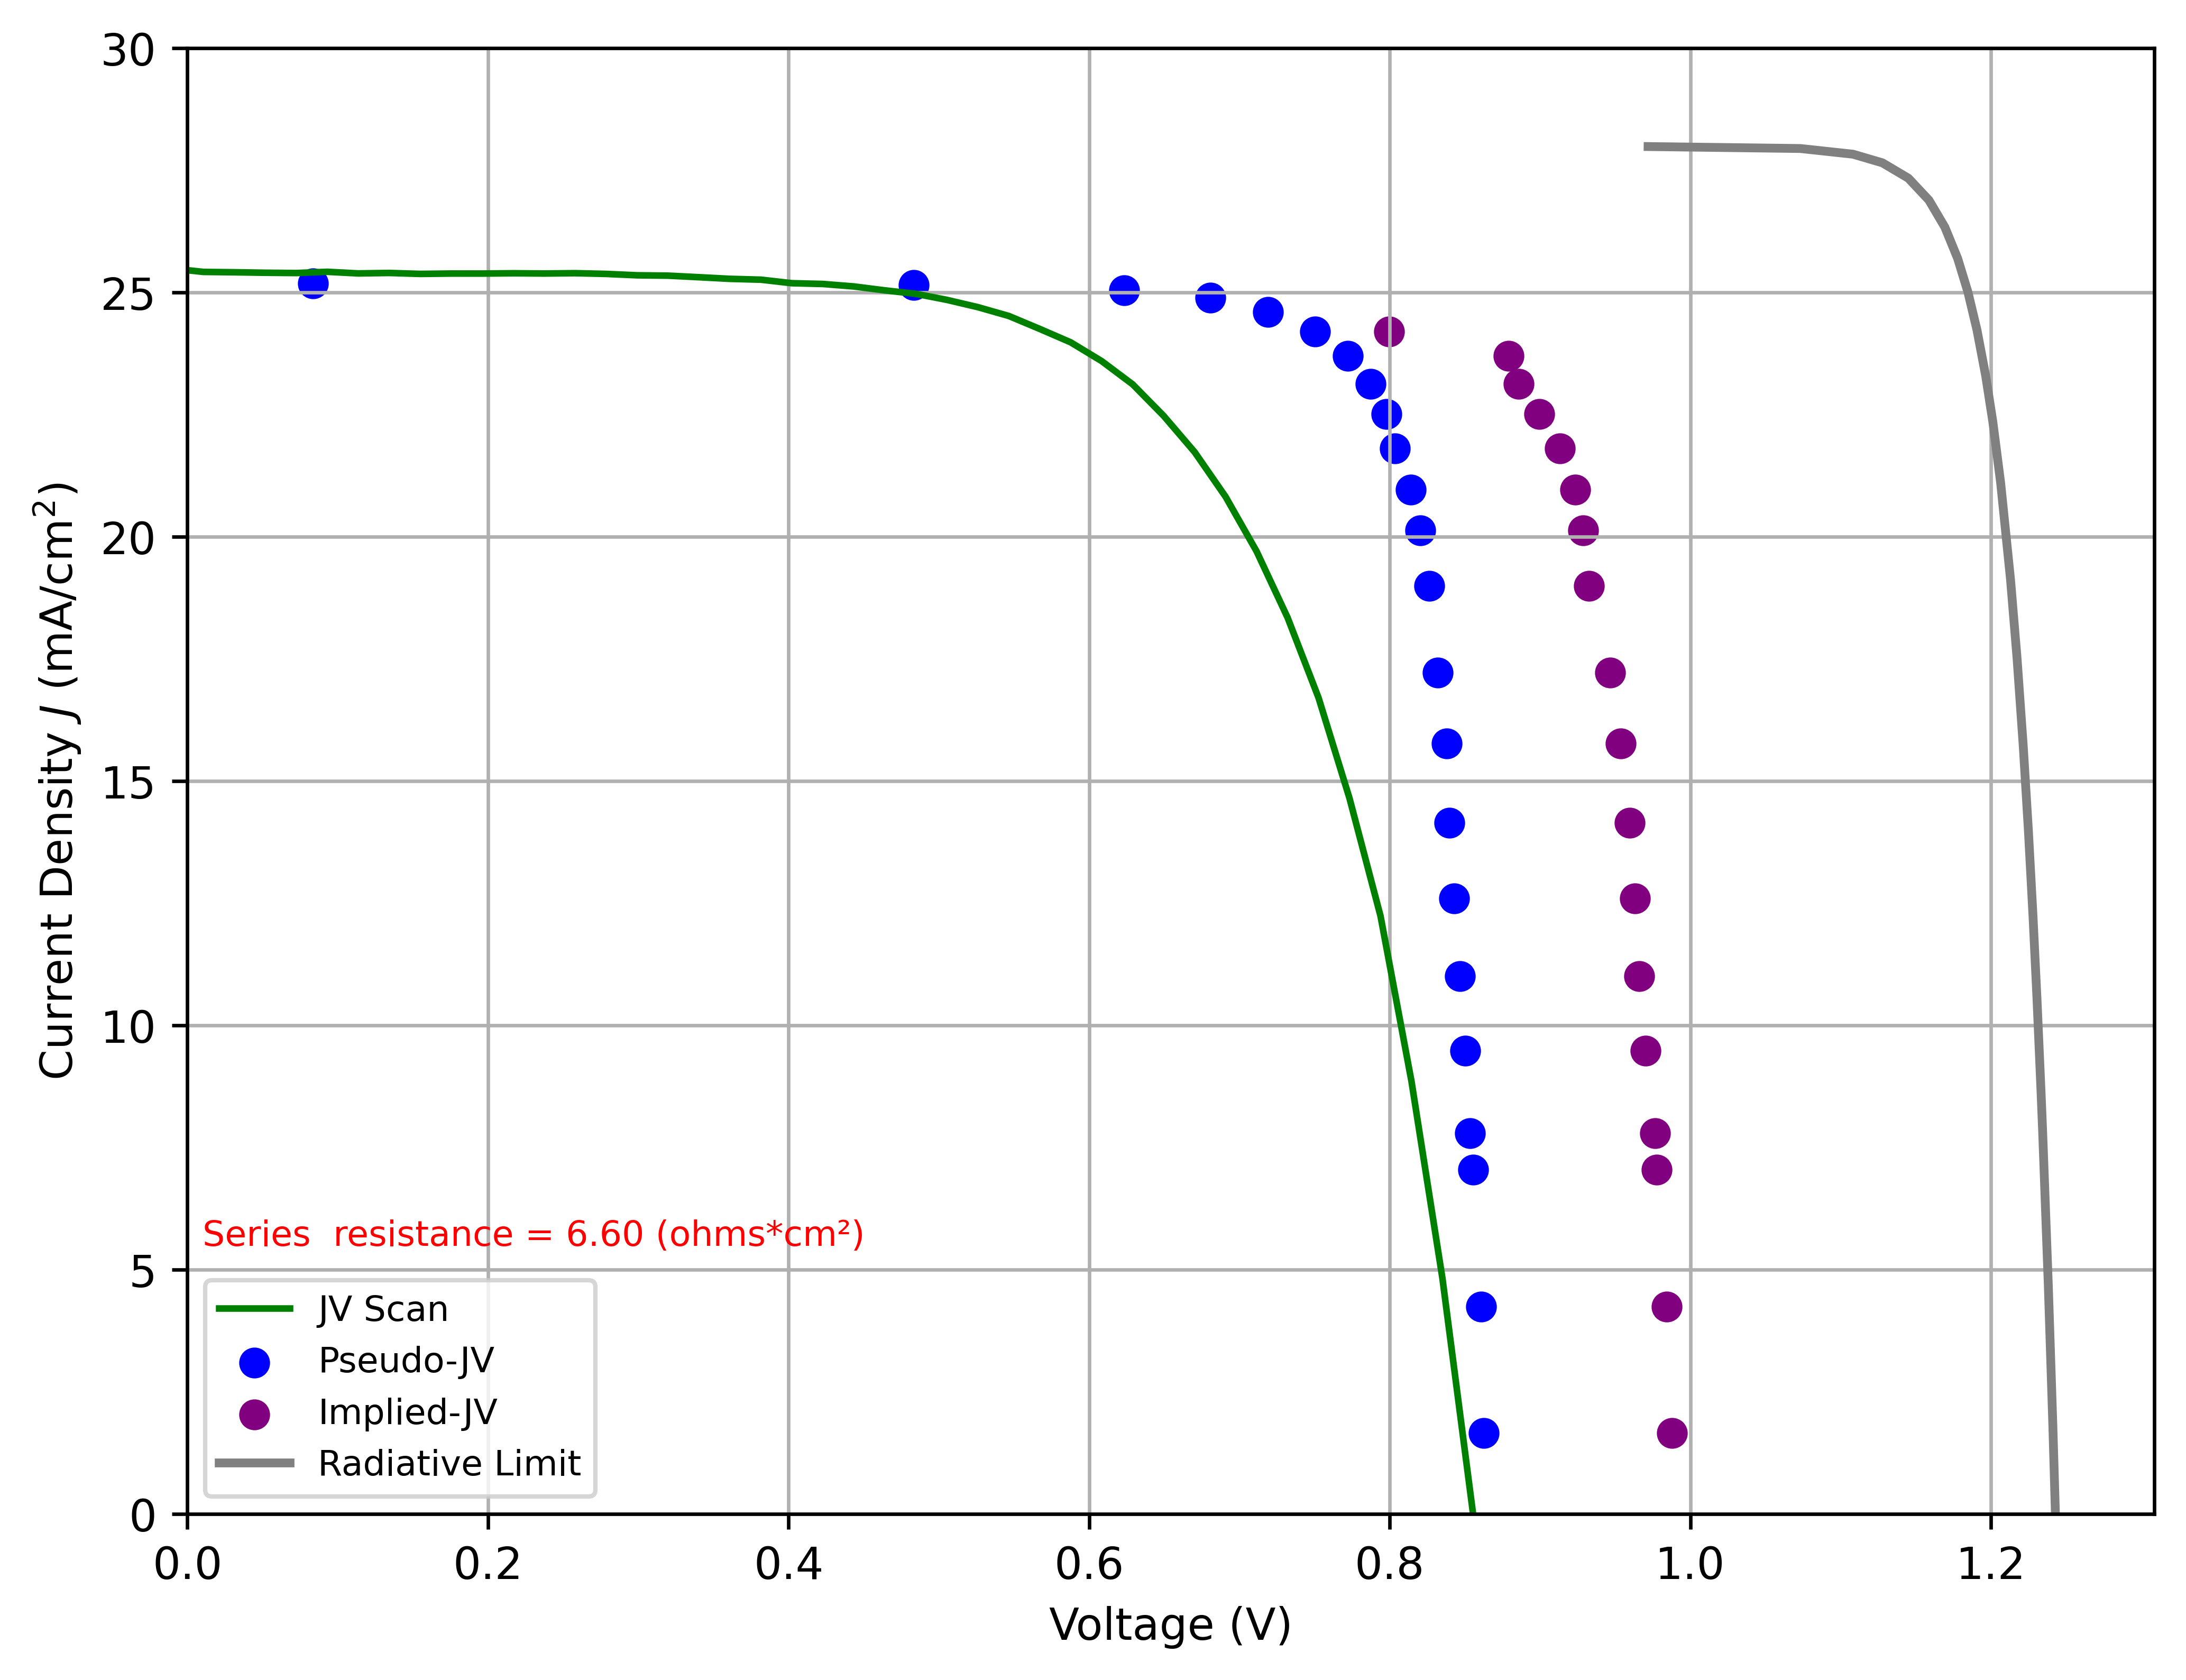

In [15]:
# Final plot with implied JV:
if "fids" in dir():
    start_index = 5 # Adjust start_index to filter out noisy iJV data
    plt.figure(figsize=(8, 6), dpi= 600)
    plt.plot(data[n]["JV_V"], data[n]["JV_J"], label="JV Scan", color='green')
    plt.scatter(data[n]['pJV_Voc'], data[n]['implied_current'], c='blue', marker='o', label='Pseudo-JV')
    plt.scatter(data[n]['qfls'][start_index:], data[n]['implied_current'][start_index:], color = 'purple', label = "Implied-JV")
    plt.plot(data[n]['qfls_rad'], data[n]['implied_current_limit'], label='Radiative Limit', color='gray', linewidth=2)
    plt.xlabel("Voltage (V)")
    plt.ylabel(r"Current Density $J$ (mA/cm$^{2}$)")
    plt.grid(True)
    plt.ylim(0,30)
    plt.xlim(0)
    plt.legend(fontsize = 8)
    #Series resistance:
    Eg = data[n]['Eg']
    legend_text = f'Series  resistance = {r_series:.2f} (ohms*cm²)'  # Format the text with two decimal places
    plt.text(0.01, 5.5, legend_text, fontsize=8, color='red')  # Adjust the coordinates and style as needed
    #plt.title("FAPbI3 Baseline J-V Characteristics")
    if save_fig == True:
        plt.savefig("Final_plot.png")

    print(f"Assumptions: \nReflection losses {REFLECTION_LOSSES} \nEmission WL = {EMISSION_WL} nm, bandgap {Eg} ev")

else:
    print("Load PLQY data folder in cwd")